## Datasets
### DATASET 1 https://archive.ics.uci.edu/ml/machine-learning-databases/glass/
### DATASET 2 https://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/
### DATASET 3 https://archive.ics.uci.edu/ml/datasets/banknote+authentication

### Outros datasets testados

### https://archive.ics.uci.edu/ml/datasets/Cervical+Cancer+Behavior+Risk
### https://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records
### https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/


In [43]:
import numpy as np
from sklearn.datasets import load_iris

iris = load_iris()
dataset1 = np.loadtxt('datasets/glass.data', delimiter=',')
dataset2 = np.loadtxt('datasets/transfusion.data', delimiter=',', skiprows=1)
dataset3 = np.loadtxt('datasets/data_banknote_authentication.txt', delimiter=',') 

In [51]:
Xi, yi = iris.data[:,2:], iris.target      # Dataset  Iris
X1, y1 = dataset1[:,4:6], dataset1[:,-1]   # Dataset 1
X2, y2 = dataset2[:,2:4], dataset2[:,-1]   # Dataset 2 
X3, y3 = dataset3[:,:2], dataset3[:,-1]    # Dataset 3

print(f"Dataset Iris: {Xi.shape}, {yi.shape}, {set(yi)}\n")
print(f"Dataset1: {X1.shape}, {y1.shape}, {set(y1)}\n")
print(f"Dataset2: {X2.shape}, {y2.shape}, {set(y2)}\n")
print(f"Dataset3: {X3.shape}, {y3.shape}, {set(y3)}")


Dataset Iris: (150, 2), (150,), {0, 1, 2}

Dataset1: (214, 2), (214,), {1.0, 2.0, 3.0, 5.0, 6.0, 7.0}

Dataset2: (748, 2), (748,), {0.0, 1.0}

Dataset3: (1372, 2), (1372,), {0.0, 1.0}


## Plot região de decisão

In [57]:
import matplotlib.pyplot as plt

def plotDecisao(modelo, X, y, titulo):
    modelo.fit(X, y)
    x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
    x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]
    ypred = modelo.predict(Xdec)
    plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
    for k in set(y):
        plt.plot(X[:,0][y==k], X[:,1][y==k], 'o')
    plt.xlabel(f"X[0]")
    plt.ylabel(f"X[1]")
    plt.title(titulo)
    plt.show()


## Árvore da tarefa

In [58]:
from sklearn.metrics import accuracy_score
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin


def valorMaisProximo(vetor, valor):
    result = vetor[(vetor - v).argmin()]
    return result


def melhorValor(x, y):
    return None

def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

class ArvoreTarefa(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = melhorCaracteristica(X,y)
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = ArvoreTarefa()
            self.maiores.fit(X[maiores,:],y[maiores])
            self.menores = ArvoreTarefa()
            self.menores.fit(X[~maiores,:],y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y


## Árvore dos vídeos

In [59]:

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin

def impureza(y): #Gini
    labels = list(set(y))
    labels.sort()
    probabilidades = np.zeros((len(labels),))
    for i,k in enumerate(labels):
        probabilidades[i] = sum(y==k)/len(y)
    result = 1 - sum(probabilidades**2)
    return result


def impurezaValor(x, y, valor):
    maiores = x>valor
    impurezaMaiores = impureza(y[maiores])
    propMaiores = sum(maiores)/len(y)
    impurezaMenores = impureza(y[~maiores])
    propMenores = sum(~maiores)/len(y)
    impurezaTotal = propMaiores*impurezaMaiores + propMenores*impurezaMenores
    return impurezaTotal, impurezaMaiores, impurezaMenores


def melhorValor(x, y):
    result = None
    menorImpureza = float('inf')
    xmax = np.max(x)
    xmin = np.min(x)
    while True:
        valor = (xmin+xmax)/2
        impTotal, impMaiores, impMenores = impurezaValor(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
            if impMaiores < impMenores:
                xmin = valor
            else:
                xmax = valor
        else:
            break
    return result, menorImpureza


def melhorCaracteristica(X, y):
    impurezas = []
    valores = []
    for caracteristica in range(X.shape[1]):
        valor, imp = melhorValor(X[:,caracteristica], y)
        impurezas.append(imp)
        valores.append(valor)
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)
    return caracteristica, valores[caracteristica], impurezas[caracteristica]


def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]


class ArvoreVideo(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = melhorCaracteristica(X,y)
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = ArvoreVideo()
            self.maiores.fit(X[maiores,:],y[maiores])
            self.menores = ArvoreVideo()
            self.menores.fit(X[~maiores,:],y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y

modelo = ArvoreVideo()
modelo.fit(Xi,yi)
ypred = modelo.predict(Xi)
acuracia = accuracy_score(yi, ypred)
print(f"Acurácia: {acuracia}")

scores = cross_validate(ArvoreVideo(), Xi, yi)
print("\nCross Validade")
print(f"Test Score: {scores['test_score']}")
print(f"Mean Test Score: {np.mean(scores['test_score'])}\n")



Acurácia: 0.9933333333333333

Cross Validade
Test Score: [0.96666667 0.96666667 0.9        0.93333333 1.        ]
Mean Test Score: 0.9533333333333334



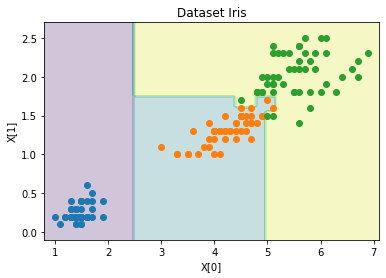

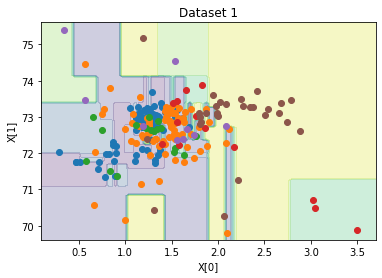

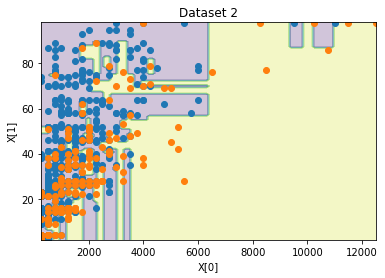

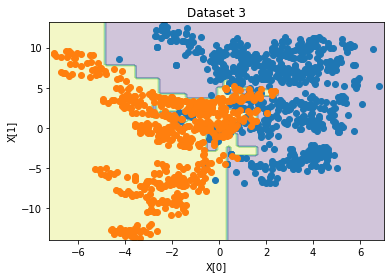

In [60]:
plotDecisao(ArvoreVideo(), Xi, yi, "Dataset Iris")
plotDecisao(ArvoreVideo(), X1, y1, "Dataset 1")
plotDecisao(ArvoreVideo(), X2, y2, "Dataset 2")
plotDecisao(ArvoreVideo(), X3, y3, "Dataset 3")